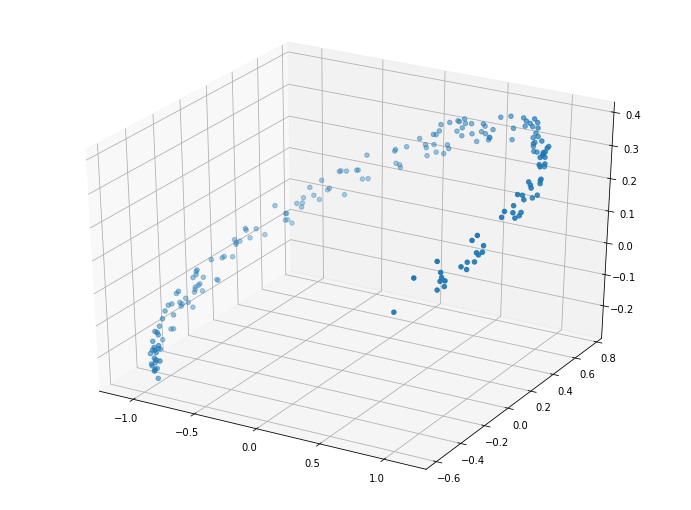

In [5]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from sklearn.preprocessing import StandardScaler   # 特征缩放

m = 200
w1, w2 = 0.1, 0.3  # 权重初始化
noise = 0.1  # 噪声数据

angles = np.random.rand(m) * 3 * np.pi / 2 - 0.5  
data = np.empty((m, 3))  # 原始数据初始化

data[:, 0] = np.cos(angles) + np.sin(angles) / 2 + noise * np.random.rand(m) / 2
data[:, 1] = np.sin(angles) * 0.7 + noise *  np.random.rand(m) / 2
data[:, 2] = data[:, 0] * w1 + data[:, 1] * w2 + noise * np.random.rand(m)

scaler = StandardScaler()
x_train = scaler.fit_transform(data[:100])
x_test = scaler.fit_transform(data[100:])


# 原始数据可视化
fig = plt.figure(figsize=[12, 9])
ax = plt.axes(projection='3d')
ax.scatter3D(data[:, 0], data[:, 1], data[:, 2]);
plt.show()

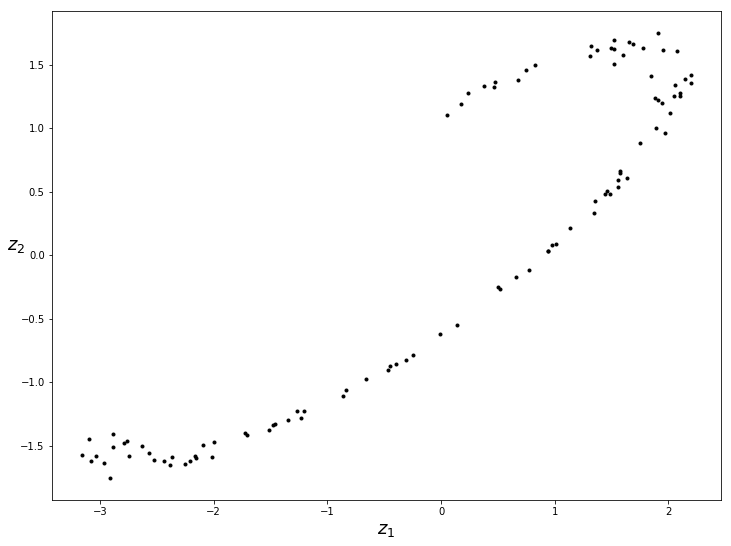

In [6]:
import tensorflow as tf

# 训练一个AE进行降维
n_inputs = 3
n_hidden = 2
n_outputs = 3

learning_rate = 0.01

# 定义自编码器的结构
X = tf.placeholder(tf.float32, shape=[None, n_inputs])
hidden = tf.layers.dense(X, n_hidden)
outputs = tf.layers.dense(hidden, n_outputs)

# 定义损失函数和优化器
loss_fun = tf.reduce_mean(tf.square(outputs - X))
optimizer = tf.train.AdamOptimizer(learning_rate)
training_op = optimizer.minimize(loss_fun)

init = tf.global_variables_initializer()

n_iterations = 1000
codings = hidden

# 训练开始
with tf.Session() as sess:
    init.run()
    for epoch in range(n_iterations):
        training_op.run(feed_dict={X:x_train})
    codings_val = codings.eval(feed_dict={X:x_test})
# 降维后的结果可视化
fig = plt.figure(figsize=[12, 9])
plt.plot(codings_val[:, 0], codings_val[:, 1], 'k.')
plt.xlabel('$z_1$', fontsize=18)
plt.ylabel('$z_2$', fontsize=18, rotation=0)
plt.show()

In [7]:
# stacked AE
from tensorflow.examples.tutorials.mnist import input_data
from functools import partial
import sys

mnist = input_data.read_data_sets("E:\\DeepLearning\\jupyter_code\\dataset\\MNIST_data\\")

n_inputs = 28 * 28
n_hidden1 = 300
n_hidden2 = 150
n_hidden3 = n_hidden1
n_outputs = n_inputs

learning_rate = 0.01
l2_reg = 0.0001   # L2正则化，惩罚因子

X = tf.placeholder(tf.float32, shape=[None, n_inputs])
he_init = tf.contrib.layers.variance_scaling_initializer()
l2_regularizer = tf.contrib.layers.l2_regularizer(l2_reg)
my_dense_layer = partial(tf.layers.dense, activation=tf.nn.relu, kernel_initializer=he_init, kernel_regularizer=l2_regularizer)
hidden1 = my_dense_layer(X, n_hidden1)
hidden2 = my_dense_layer(hidden1, n_hidden2)
hidden3 = my_dense_layer(hidden2, n_hidden3)
outputs = my_dense_layer(hidden3, n_outputs, activation=None)

reconstruction_loss = tf.reduce_mean(tf.square(outputs - X))
reg_losses = tf.get_collection(tf.GraphKeys.REGULARIZATION_LOSSES)
loss = tf.add_n([reconstruction_loss] + reg_losses)
optimizer = tf.train.AdamOptimizer(learning_rate)
training_op = optimizer.minimize(loss)

init = tf.global_variables_initializer()

saver = tf.train.Saver()

n_epochs = 5
batch_size = 150
# 训练开始
with tf.Session() as sess:
    init.run()
    for epoch in range(n_epochs):
        n_batches = mnist.train.num_examples // batch_size  # batch_size的个数
        for i in range(n_batches):
            print("\r{}%".format(100 * i // n_batches), end="")
            sys.stdout.flush()
            X_batch, y_batch = mnist.train.next_batch(batch_size)
            sess.run(training_op, feed_dict={X:X_batch})
        loss_train = reconstruction_loss.eval(feed_dict={X:X_batch})
        print("\r{}".format(epoch), "Train MSE:", loss_train)
        saver.save(sess, "E:\\DeepLearning\\jupyter_code\\model\\my_model_all_layers.ckpt")

Extracting E:\DeepLearning\jupyter_code\dataset\MNIST_data\train-images-idx3-ubyte.gz
Extracting E:\DeepLearning\jupyter_code\dataset\MNIST_data\train-labels-idx1-ubyte.gz
Extracting E:\DeepLearning\jupyter_code\dataset\MNIST_data\t10k-images-idx3-ubyte.gz
Extracting E:\DeepLearning\jupyter_code\dataset\MNIST_data\t10k-labels-idx1-ubyte.gz
0 Train MSE: 0.037056815
1 Train MSE: 0.0344879
2 Train MSE: 0.033393763
3 Train MSE: 0.03485773
4 Train MSE: 0.034572046


INFO:tensorflow:Restoring parameters from E:\DeepLearning\jupyter_code\model\my_model_all_layers.ckpt


NameError: name 'plot_image' is not defined

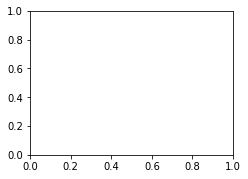

In [8]:
# 上述结果的可视化
def show_reconstructed_digits(X, outputs, model_path=None, n_test_digits=3):
    with tf.Session() as sess:
        if model_path:
            saver.restore(sess, model_path)
        X_test = mnist.test.images[:n_test_digits]
        outputs_val = outputs.eval(feed_dict={X:X_test})
    fig = plt.figure(figsize=(8, 3*n_test_digits))
    for digit_index in range(n_test_digits):
        plt.subplot(n_test_digits, 2, digit_index * 2 + 1)
        plot_image(X_test[digit_index])   # 此处代码有问题!
        plt.subplot(n_test_digits, 2, digit_index * 2 + 2)
        plot_image(outputs_val[digit_index])

show_reconstructed_digits(X, outputs, "E:\\DeepLearning\\jupyter_code\\model\\my_model_all_layers.ckpt")

In [9]:
# VAE变分自编码器
from functools import partial
n_inputs = 28 * 28
n_hidden1 = 500
n_hidden2 = 500
n_hidden3 = 20
n_hidden4 = n_hidden2
n_hidden5 = n_hidden1
n_outputs = n_inputs
learning_rate = 0.001

initializer = tf.contrib.layers.variance_scaling_initializer()

my_dense_layer = partial(tf.layers.dense, activation=tf.nn.relu, kernel_initializer=initializer)

X = tf.placeholder(tf.float32, shape=[None, n_inputs])
hidden1 = my_dense_layer(X, n_hidden1)
hidden2 = my_dense_layer(hidden1, n_hidden2)
hidden3_mu = my_dense_layer(hidden2, n_hidden3, activation=None)
hidden3_sigma = my_dense_layer(hidden2, n_hidden3, activation=None)
noise = tf.random_normal(tf.shape(hidden3_sigma), dtype=tf.float32)

hidden3 = hidden3_mu + hidden3_sigma * noise
hidden4 = my_dense_layer(hidden3, n_hidden4)
hidden5 = my_dense_layer(hidden4, n_hidden5)
logits = my_dense_layer(hidden5, n_outputs, activation=None)
outputs = tf.sigmoid(logits)

x_entropy = tf.nn.sigmoid_cross_entropy_with_logits(labels=X, logits=logits)
reconstruction_loss = tf.reduce_sum(x_entropy)

eps = 1e-10   # 防止出现log(0)
latent_loss =  0.5 * tf.reduce_sum(tf.square(hidden3_sigma) + tf.square(hidden3_mu) - 1 - tf.log(eps + tf.square(hidden3_sigma)))
loss = latent_loss + reconstruction_loss

optimizer = tf.train.AdamOptimizer(learning_rate)
training_op = optimizer.minimize(loss)

init = tf.global_variables_initializer()
saver = tf.train.Saver()

n_digits = 60
n_epochs = 50
batch_size = 150

with tf.Session() as sess:
    init.run()
    for epoch in range(n_epochs):
        n_batches = mnist.train.num_examples // batch_size
        for i in range(n_batches):
            print("\r{}%".format(100 * i // n_batches), end="")
            sys.stdout.flush()
            X_batch, y_batch = mnist.train.next_batch(batch_size)
            sess.run(training_op, feed_dict={X:X_batch})
        loss_val, reconstruction_loss_val, latent_loss_val = sess.run([loss, reconstruction_loss, latent_loss], feed_dict={X:X_batch})
        print("\r{}".format(epoch), "Train total loss:", loss_val, "\tReconstruction loss:", reconstruction_loss_val, "\tLatent loss:", latent_loss_val)
        saver.save(sess, "E:\\DeepLearning\\jupyter_code\\model\\my_model_variational.ckpt")
    codings_rnd =  np.random.normal(size=[n_digits, n_hidden3])
    outputs_val = outputs.eval(feed_dict={hidden3: codings_rnd})


0 Train total loss: 22636.707 	Reconstruction loss: 19963.215 	Latent loss: 2673.4924
1 Train total loss: 21884.715 	Reconstruction loss: 19045.207 	Latent loss: 2839.5068
2 Train total loss: 21457.66 	Reconstruction loss: 18455.703 	Latent loss: 3001.9565
3 Train total loss: 21654.059 	Reconstruction loss: 18522.172 	Latent loss: 3131.8862
4 Train total loss: 20141.074 	Reconstruction loss: 17006.77 	Latent loss: 3134.3042
5 Train total loss: 21873.559 	Reconstruction loss: 18780.031 	Latent loss: 3093.5269
69% Train total loss: 20185.531 	Reconstruction loss: 17683.61 	Latent loss: 2501.9224
7 Train total loss: 19224.268 	Reconstruction loss: 16457.674 	Latent loss: 2766.594
8 Train total loss: 17990.115 	Reconstruction loss: 15089.262 	Latent loss: 2900.854
9 Train total loss: 17461.04 	Reconstruction loss: 14624.752 	Latent loss: 2836.288
10 Train total loss: 18699.303 	Reconstruction loss: 15770.1875 	Latent loss: 2929.1145
11 Train total loss: 17231.541 	Reconstruction loss: 1439

In [ ]:
# 结果可视化
plt.figure(figsize=(8, 50))
for i in range(n_digits):
    plt.subplot(n_digits, 10, i+1)
    plot_image(outputs_val[i])